In [18]:
import sys
from helpers import *
#!python ../helpers.py

In [19]:
# data definitions

path_data = "../ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
scaler_one = MinMaxScaler()
slice_idx = 15000
sf = 2

# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx,sf=sf)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals_one,sf=sf)

# extra transform step for output_cols_one in lieu of z mass

train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])



Slicing data into inputs/outputs
	- outputs.shape: (15000, 4)
Scaling input data
	- inputs_scaled.shape: (15000, 300, 200, 1)
Slicing data into inputs/outputs
	- outputs.shape: (5000, 4)
Scaling input data
	- inputs_scaled.shape: (5000, 300, 200, 1)


In [3]:
input_shape = train_inputs_scaled_one[0,:,:].shape
output_shape = train_outputs_scaled_one.shape[1]

print(input_shape)
output_shape

(600, 400, 1)


4

# Train a DNN

In [5]:
inputs = Input(shape=input_shape)
nn_dense = Flatten()(inputs)
nn_dense = Dense(1024,activation='relu')(nn_dense)
nn_dense = Dense(512,activation='relu')(nn_dense)
nn_dense = Dense(512,activation='relu')(nn_dense)
nn_dense = Dense(output_shape,activation='softmax')(nn_dense)
model = Model(inputs, nn_dense)

In [6]:
model.output_shape

(None, 4)

In [7]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 200, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 60000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              61441024  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
Total params: 62,230,532
Trainable params: 62,230,532
Non-trainable params: 0
_________________________________________________

In [8]:
x = train_inputs_scaled_one
xv = valid_inputs_scaled_one
y = train_outputs_scaled_one
yv = valid_outputs_scaled_one
batch_size = 256
epochs = 10
verbose = 1


model.fit(x, y, batch_size=batch_size, epochs=epochs,
                       verbose=verbose, validation_data=(xv, yv))

Epoch 1/10
24/24 [==============================] - 1s 39ms/step - loss: 0.3248 - val_loss: 0.3308
Epoch 2/10
24/24 [==============================] - 1s 38ms/step - loss: 0.3331 - val_loss: 0.3308
Epoch 3/10
24/24 [==============================] - 1s 35ms/step - loss: 0.3331 - val_loss: 0.3308
Epoch 4/10
24/24 [==============================] - 1s 33ms/step - loss: 0.3331 - val_loss: 0.3308
Epoch 5/10
24/24 [==============================] - 1s 33ms/step - loss: 0.3331 - val_loss: 0.3308
Epoch 6/10
24/24 [==============================] - 1s 33ms/step - loss: 0.3331 - val_loss: 0.3308
Epoch 7/10
24/24 [==============================] - 1s 34ms/step - loss: 0.3331 - val_loss: 0.3308
Epoch 8/10
24/24 [==============================] - 1s 33ms/step - loss: 0.3331 - val_loss: 0.3308
Epoch 9/10
24/24 [==============================] - 1s 30ms/step - loss: 0.3331 - val_loss: 0.3308
Epoch 10/10
24/24 [==============================] - 1s 32ms/step - loss: 0.3331 - val_loss: 0.3308


In [4]:
class DeepNeuralNetwork(object):
    """
    A Conv2D Neural Network Model that can support arbitrary numbers of layers.

    Attributes:
        filters: List of number of filters in each Conv2D layer
        kernel_sizes: List of kernel sizes in each Conv2D layer
        conv2d_activation: Type of activation function for conv2d layers
        pool_sizes: List of Max Pool sizes
        dense_sizes: Sizes of dense layers
        dense_activation: Type of activation function for dense layers
        output_activation: Type of activation function for output layer
        lr: Optimizer learning rate
        optimizer: Name of optimizer or optimizer object.
        adam_beta_1: Exponential decay rate for the first moment estimates
        adam_beta_2: Exponential decay rate for the first moment estimates
        sgd_momentum: Stochastic Gradient Descent momentum
        decay: Optimizer decay
        loss: Name of loss function or loss object
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
    def __init__(self, dense_sizes=(64,), dense_activation="relu", output_activation="softmax",
                 lr=0.001, optimizer="adam",  adam_beta_1=0.9, adam_beta_2=0.999,
                 sgd_momentum=0.9, decay=0, loss="mse", batch_size=32, epochs=2, verbose=0):
        self.dense_sizes = dense_sizes
        self.dense_activation = dense_activation
        self.output_activation = output_activation
        self.lr = lr
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.sgd_momentum = sgd_momentum
        self.decay = decay
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = None
    def build_neural_network(self, input_shape, output_shape):
        """Create Keras neural network model and compile it."""
        conv_input = Input(shape=(input_shape), name="input")
        nn_model = conv_input
        nn_model = Flatten()(nn_model)
        for h in range(len(self.dense_sizes)):
            nn_model = Dense(self.dense_sizes[h], activation=self.dense_activation, name=f"dense_{h:02d}")(nn_model)
        nn_model = Dense(output_shape, activation=self.output_activation, name=f"dense_output")(nn_model)
        self.model = Model(conv_input, nn_model)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        self.model.summary()

    def fit(self, x, y, xv, yv):
        if len(y.shape) == 1:
            output_shape = 1
        else:
            output_shape = y.shape[1]
        input_shape = x.shape[1:]
        self.build_neural_network(input_shape, output_shape)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs,
                       verbose=self.verbose, validation_data=(xv, yv))
        return self.model.history.history

    def predict(self, x):
        y_out = self.model.predict(x, batch_size=self.batch_size)
        return y_out
    def predict_proba(self, x):
        y_prob = self.model.predict(x, batch_size=self.batch_size)
        return y_prob


In [132]:
15000/2

7500.0

In [8]:
model_name = "dnn1"
dense_sizes = [7500, 2048, 1024, 512, 512, 512, 512, 512, 512]
dense_activation = "relu"
lr = 0.01
optimizer = "sgd"
loss = "mae"
batch_size = 256
epochs = 50
verbose = 1

In [9]:
one_start = datetime.now()
#with tf.device('/device:GPU:0'):
mod = DeepNeuralNetwork(dense_sizes=dense_sizes, dense_activation=dense_activation,
                 lr=lr, optimizer=optimizer, loss=loss, batch_size=batch_size, epochs=epochs, verbose=verbose)
mod.fit(train_inputs_scaled_one, train_outputs_scaled_one, valid_inputs_scaled_one, valid_outputs_scaled_one)
    
train_preds_scaled_one = pd.DataFrame(mod.predict(train_inputs_scaled_one), columns=output_cols_one)
valid_preds_scaled_one = pd.DataFrame(mod.predict(valid_inputs_scaled_one), columns=output_cols_one)
print(f"Running model took {datetime.now() - one_start} time")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300, 200, 1)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_00 (Dense)             (None, 7500)              450007500 
_________________________________________________________________
dense_01 (Dense)             (None, 2048)              15362048  
_________________________________________________________________
dense_02 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_03 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_04 (Dense)             (None, 512)               2626

In [11]:
# Plot a single hologram with the particles overlaid
def plot_hologram(h, img, outputs="none"):
    """
    Given a hologram number, plot hologram and particle point
    
    Args: 
        h: (int) hologram number
    
    Returns:
        print of pseudocolor plot of hologram and hologram particles
    """    
    x_vals = np.linspace(-888, 888, img[h, :, :, 0].shape[0])
    y_vals = np.linspace(-592, 592, img[h, :, :, 0].shape[1])

    plt.figure(figsize=(12, 8))
    plt.pcolormesh(x_vals, y_vals, img[h, :, :, 0].T, cmap="RdBu_r")
    outputs = outputs[h,:]
    if not outputs=="none":
        plt.scatter(outputs[0], #x
                    outputs[1], #y
                    outputs[3] ** 2, #d
                    outputs[2], #z
                    cmap="cool")
        str = f"d: {out_pred[h_idx,2]:.1f} µm"
        #plt.annotate("str",(outputs[0], outputs[1]))
    plt.xlabel("horizontal particle position (µm)", fontsize=16)
    plt.ylabel("vertical particle position (µm)", fontsize=16)
    plt.title("Hologram and predicted particle positions plotted in four dimensions", fontsize=20, pad=20)
    #plt.colorbar().set_label(label="z-axis particle position (µm)", size=16)


In [16]:
out_pred

array([[-4.4733511e+02, -3.1348376e+02,  5.0034125e+04,  3.3288025e+01],
       [-4.5974698e+02, -3.1056464e+02,  4.9067039e+04,  3.3850140e+01],
       [-4.4687909e+02, -3.0516962e+02,  5.1539090e+04,  3.2400837e+01],
       ...,
       [-4.5785376e+02, -3.0216489e+02,  5.0909383e+04,  3.2801693e+01],
       [-4.4962747e+02, -3.1034711e+02,  4.9815055e+04,  3.3295948e+01],
       [-4.6160477e+02, -3.0762943e+02,  4.8775590e+04,  3.3879463e+01]],
      dtype=float32)

/home/gridsan/lmilechin/.conda/envs/ai4ess2/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


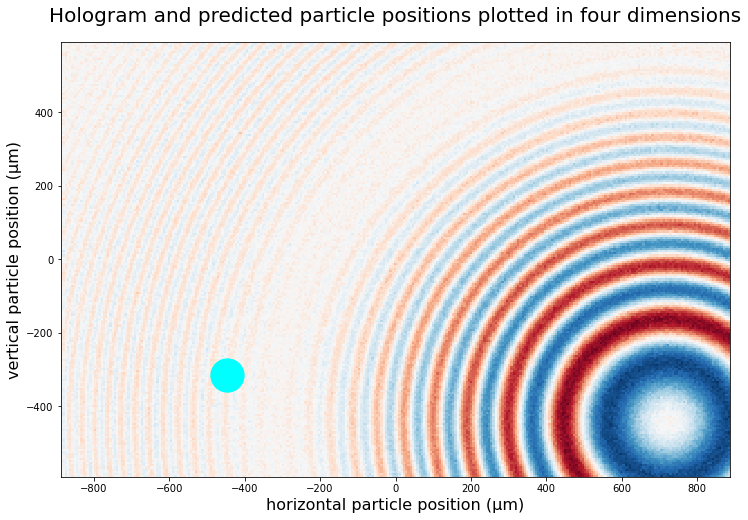

In [17]:
h_idx = 0
train_preds_one = pd.DataFrame(scaler_one.inverse_transform(train_preds_scaled_one.values), columns=output_cols_one)
valid_preds_one = pd.DataFrame(scaler_one.inverse_transform(valid_preds_scaled_one.values), columns=output_cols_one)
out_pred = train_preds_one.values

plot_hologram(h_idx,train_inputs_scaled_one, out_pred)

In [13]:
img.T.shape

(1, 200, 300)

In [38]:
out_pred = mod.predict(train_inputs_scaled_one)

In [40]:
out_pred.shape


(6000, 4)